# 1. 自回归模型（Autoregressive Model）

自回归（AR）模型是一种时间序列模型，用于描述当前时刻的数据如何依赖于过去时刻的数据。它假设当前状态可以通过一个线性组合的方式由历史观测值来表示。

## 数学表达式：
自回归模型的一般形式为：
$$
y_t = \alpha + \sum_{i=1}^{p} \beta_i y_{t-i} + \epsilon_t
$$
其中：
- $y_t$：表示时刻$t$的观测值。
- $\alpha$：常数项，表示模型的偏移量。
- $\beta_i$：表示过去第$i$个时刻对当前值的影响系数（AR系数）。
- $p$：模型的阶数，表示回归时使用的过去时刻的数量。
- $\epsilon_t$：误差项，通常假设为白噪声，表示观测误差或系统无法捕捉的随机波动。

## 关键特点：
- **无记忆性**：当前时刻的值仅依赖于其前$p$个时刻的观测值，而与更早的观测值无关。
- **线性关系**：假设数据之间是线性关系，因此适用于数据变化呈线性趋势的情况。

## 应用场景：
- 股票价格预测。
- 气象数据分析。
- 经济数据建模。

# 2. 马尔可夫模型（Markov Model）

马尔可夫模型是一类随机过程模型，描述一个系统从一个状态转移到另一个状态的过程。马尔可夫模型的核心特性是**马尔可夫性**，即系统的未来状态只与当前状态有关，与过去的历史状态无关。

## 数学表达式：
马尔可夫链的转移概率通常表示为：
$$
P(s_t | s_{t-1}, s_{t-2}, \dots, s_0) = P(s_t | s_{t-1})
$$
其中：
- $P(s_t | s_{t-1})$：表示在时刻$t-1$处于状态$s_{t-1}$时，转移到时刻$t$的状态$s_t$的概率。
- 系统的状态空间为$\{s_1, s_2, \dots, s_n\}$，每个状态的转移概率可以构成一个**转移矩阵**$P$。

## 关键特点：
- **无记忆性**：未来的状态只与当前状态有关，而与历史状态无关。
- **状态转移**：系统的变化是通过状态之间的转移来描述的，每个状态到另一个状态的转移有一定的概率。

## 应用场景：
- 语音识别（隐马尔可夫模型）。
- 机器人导航（路径规划）。
- 文本生成、自然语言处理。

# 3. 因果关系（Causal Relationship）

因果关系是指一个事件（原因）会直接影响另一个事件（结果）。在数据分析和建模中，因果关系的建模非常重要，特别是在深度学习中，尤其是处理时间序列数据时。

## 数学表达式：
因果关系在数学上可以通过结构方程模型（SEM）、格兰杰因果检验（Granger Causality）等方法来描述。对于格兰杰因果检验，假设有两个时间序列$x_t$和$y_t$，我们可以表示因果关系为：
$$
y_t = \sum_{i=1}^{p} \beta_i x_{t-i} + \epsilon_t
$$
或者
$$
x_t = \sum_{i=1}^{p} \gamma_i y_{t-i} + \eta_t
$$
其中：
- $\beta_i$和$\gamma_i$是回归系数，表示变量间的影响程度。
- $\epsilon_t$和$\eta_t$是误差项，表示无法捕捉的噪声。

## 关键特点：
- **因果性**：因果关系不仅仅描述相关性，还说明了一个变量如何影响另一个变量。
- **时间顺序性**：因果关系通常遵循时间顺序，前一个事件是后一个事件的原因。

## 应用场景：
- 经济学中的政策影响分析。
- 物理学中事件的因果推理。
- 神经科学中脑部活动与行为之间的因果关系分析。

# 实操
## 训练

首先生成一些数据：使用正弦函数和一些可加性噪声来生成序列数据，时间步为1, 2, . . . , 1000。

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

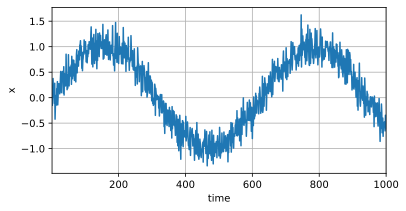

In [2]:
T = 1000 # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [3]:
# 定义时间窗口大小 tau，表示用过去 tau 个时间步的数据来预测下一个时间步
tau = 4

# 初始化特征矩阵 features，形状为 (T - tau, tau)
# T - tau 表示可以生成的样本数量，tau 表示每个样本的特征数量（时间窗口大小）
features = torch.zeros((T - tau, tau))

# 通过循环填充特征矩阵
for i in range(tau):
    # 将时间序列 x 的滑动窗口数据填充到 features 中
    # x[i: T - tau + i] 表示从第 i 个时间步开始，取长度为 T - tau 的子序列
    features[:, i] = x[i: T - tau + i]

# 构建标签 labels，表示每个样本对应的目标值（下一个时间步的值）
# x[tau:] 表示从第 tau 个时间步开始的所有值，reshape((-1, 1)) 将其转换为列向量
labels = x[tau:].reshape((-1, 1))

# 定义批量大小 batch_size 和训练样本数量 n_train
batch_size, n_train = 16, 600

# 创建训练数据加载器 train_iter
# 使用前 n_train 个样本作为训练数据，features[:n_train] 是特征，labels[:n_train] 是标签
# batch_size 表示每次迭代返回的批量大小，is_train=True 表示这是训练数据
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

在这里，我们使用一个相当简单的架构训练模型：一个拥有两个全连接层的多层感知机，ReLU激活函数和平方损失。

In [4]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        
# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net
    
# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

现在开始准备实现模型的训练，实现训练的基本代码与之前的基本类似

In [5]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
            f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.056779
epoch 2, loss: 0.050838
epoch 3, loss: 0.047926
epoch 4, loss: 0.048358
epoch 5, loss: 0.046080


## 预测

训练的损失是很小的，所以期望其有着较好的工作效果。现在来进行检验，首先是首先是检
查模型预测下一个时间步的能力，也就是单步预测（one‐step‐ahead prediction）。

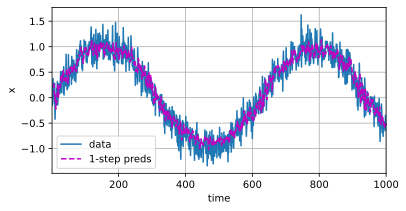

In [6]:
onestep_preds = net(features)

d2l.plot([time, time[tau:]], 
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

所以其实我们可以从最后的结果看出单步预测的结果是不错的，如果采取的是多步预测呢

In [7]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

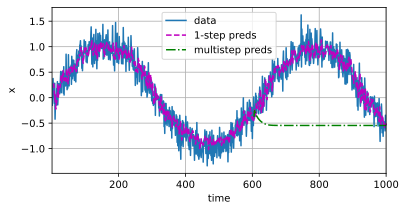

In [8]:
d2l.plot([time, time[tau:], time[n_train + tau:]],
            [x.detach().numpy(), onestep_preds.detach().numpy(),
            multistep_preds[n_train + tau:].detach().numpy()], 'time',
            'x', legend=['data', '1-step preds', 'multistep preds'],
            xlim=[1, 1000], figsize=(6, 3))

绿线的预测显然并不理想

基于k = 1, 4, 16, 64，通过对整个序列预测的计算，让我们更仔细地看一下k步预测的困难。

In [9]:
max_steps = 64

In [10]:
# 初始化特征矩阵 features，形状为 (T - tau - max_steps + 1, tau + max_steps)
# T - tau - max_steps + 1 是样本数量，tau + max_steps 是每个样本的特征数量
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))

# 填充前 tau 列，使用时间序列 x 的观测值
# 列 i（i < tau）是来自 x 的观测，其时间步从 i 到 i + T - tau - max_steps + 1
for i in range(tau):
    # 从 x 中提取子序列，赋值给 features 的第 i 列
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 填充后 max_steps 列，使用模型的预测值
# 列 i（i >= tau）是来自 (i - tau + 1) 步的预测，其时间步从 i 到 i + T - tau - max_steps + 1
for i in range(tau, tau + max_steps):
    # 提取当前样本的前 tau 个时间步的数据（包括观测值和预测值）
    # 使用模型 net 预测下一个时间步的值
    # 将预测结果赋值给 features 的第 i 列
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

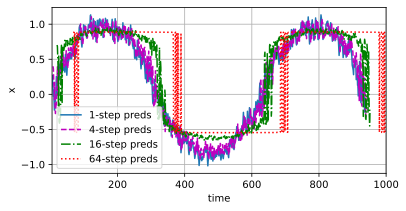

In [11]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
            [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
            legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
            figsize=(6, 3))